In [1]:
!pip install wordcloud

     |████████████████████████████████| 366 kB 8.7 MB/s eta 0:00:01


In [2]:
#!pip install collections

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [31]:
import numpy as np 
import pandas as pd 
import os
import itertools

#plots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from PIL import Image
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.util import ngrams


from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

import re
from collections import Counter

In [32]:
n=pd.read_csv('Tnews1.csv')

In [33]:
n.head()

,text,label
0,The 8-year-old boy who was killed by Boston Ma...,1
1,"Such a tragedy today in Boston, there are no w...",0
2,Disgusting. RT @WBCSays: THANK GOD FOR THE BOS...,1
3,An 8 year old boy was at the finish line waiti...,1
4,Mi preocupación por Boston y Venezuela es dire...,0


In [34]:
print("Total number of records in data: ",len(n))

Total number of records in data:  4952


In [35]:
n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4952 entries, 0 to 4951
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4952 non-null   object
 1   label   4952 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 77.5+ KB


In [36]:
#covid['user_location'].fillna('unknown', inplace=True)

In [37]:
#the count of tweets location wise
#covid['user_location'].value_counts()

In [38]:
#!pip install pycountry

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
var1 = n.groupby('label').count()['text'].reset_index().sort_values(by='text',ascending=False)
sns.set_style("white")
sns.set_palette("Set2")
a=var1.style.background_gradient()
a

,label,text
0,0,3714
1,1,1238


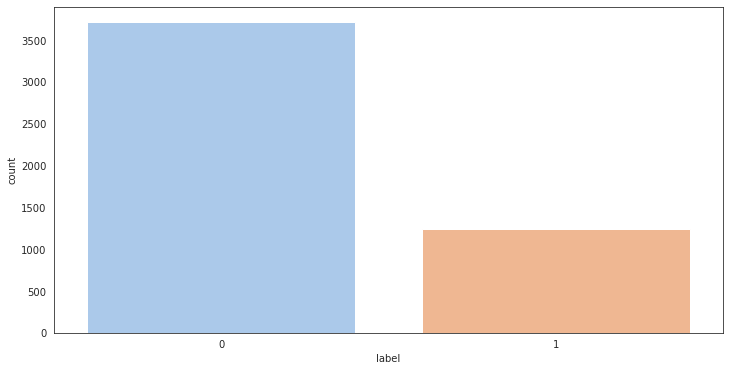

In [42]:
plt.figure(figsize=(12,6))
b=sns.countplot(x='label',data=n,palette="pastel") #palette = flare or Set3
fig=b.get_figure()
#fig.savefig('1.png',dpi=300)

In [12]:
#Top 5 location by no. of tweet
def plot_bar(x,y,title,x_label,y_label):
    fig = go.Figure(data=[go.Bar(
                x=x,
                y=y,
                text=y,
                textposition='auto',
            )])

    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label
    )

    fig.show()

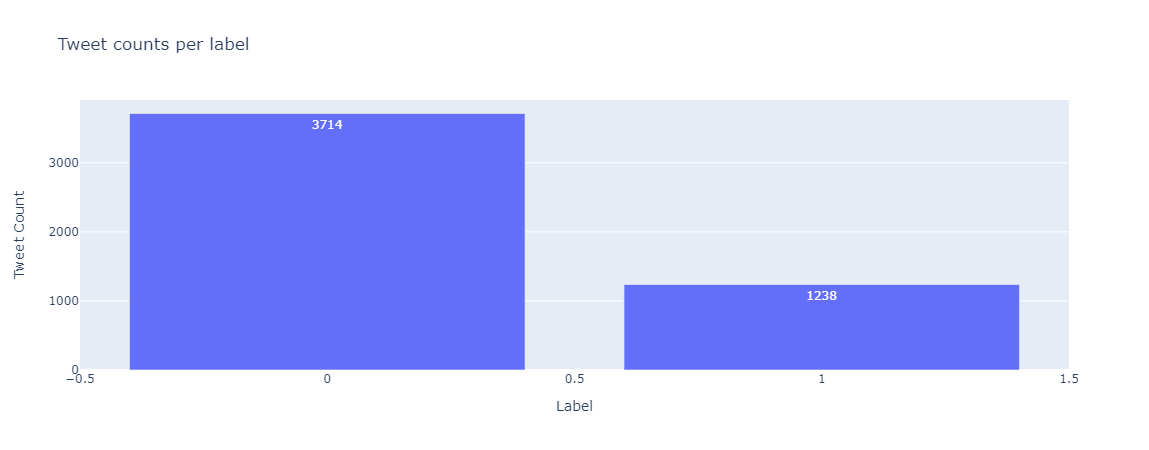

In [19]:
plot_bar(n['label'].value_counts().index[0:2],
         n['label'].value_counts().values[0:2],
         "Tweet counts per label",
         "Label",
         "Tweet Count")

In [20]:
#What hashtags has been viral/most used in covid tweets?
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
n['hash']=n['text'].apply(lambda x:find_hash(x))


In [21]:
hastags=list(n[(n['hash'].notnull())&(n['hash']!="")]['hash'])
hastags = [each_string.lower() for each_string in hastags]
hash_df=dict(Counter(hastags))
top_hash_df=pd.DataFrame(list(hash_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_hash_df.head(4)

,word,count
1,prayforboston,815
4,boston,283
5,bostonmarathon,57
16,name,37


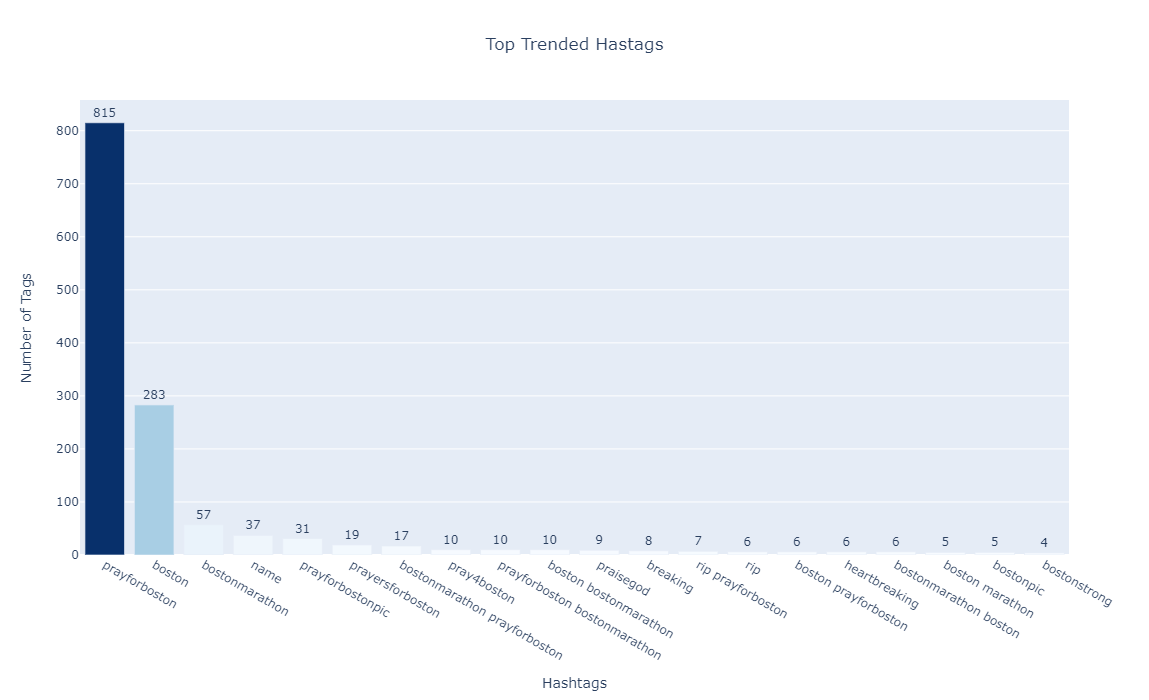

In [22]:
fig = go.Figure(go.Bar(
    x=top_hash_df['word'],y=top_hash_df['count'],
    marker={'color': top_hash_df['count'], 
    'colorscale': 'blues'},  
    text=top_hash_df['count'],
    textposition = "outside",
))
fig.update_layout(title_text='Top Trended Hastags',xaxis_title="Hashtags ",
                  yaxis_title="Number of Tags ",template="plotly",height=700,title_x=0.5)
fig.show()

In [23]:
#find most mentioned user or organization in covid tweets
def find_at(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
n['mention']=n['text'].apply(lambda x:find_at(x))


In [24]:
mentions=list(n[(n['mention'].notnull())&(n['mention']!="")]['mention'])
mentions = [each_string.lower().split() for each_string in mentions]
mentions=list(itertools.chain.from_iterable(mentions))
mention_df=dict(Counter(mentions))
top_mention_df=pd.DataFrame(list(mention_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_mention_df.head(10)

,word,count
0,wbcsays,42
81,wsj,39
50,ap,17
1,hopeforboston,15
34,detikcom,13
43,wsjbreakingnews,12
115,youtube,11
2,barackobama,9
10,breakingnews,8
204,thematthewkeys,7


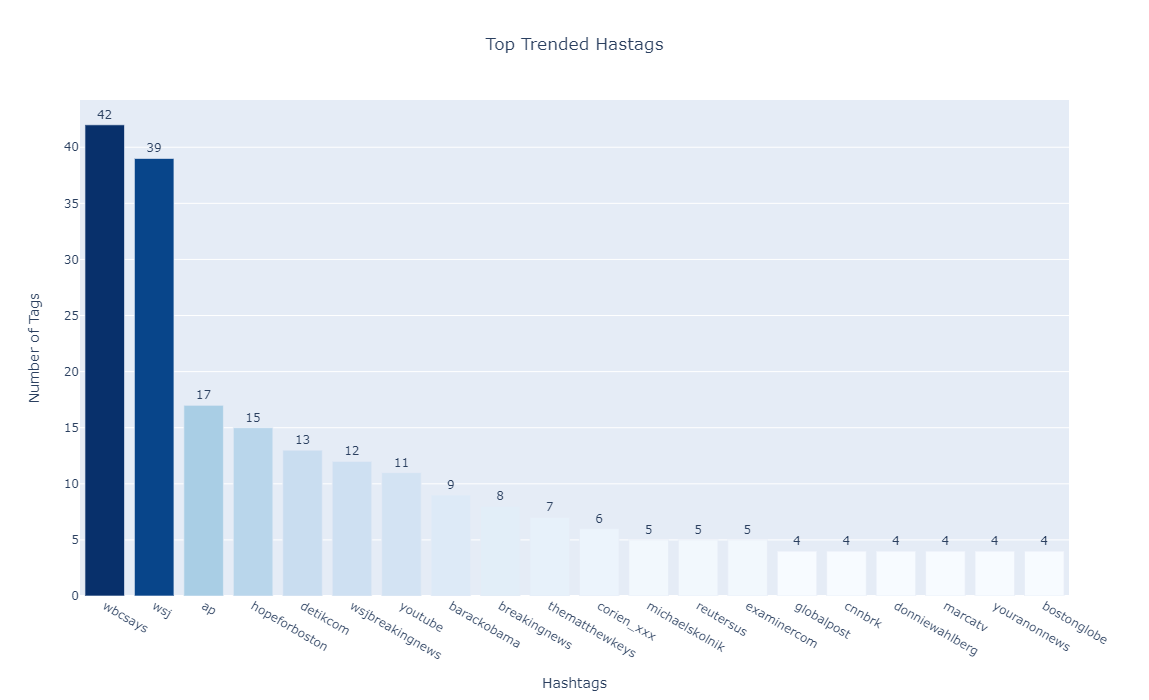

In [25]:
fig = go.Figure(go.Bar(
    x=top_mention_df['word'],y=top_mention_df['count'],
    marker={'color': top_mention_df['count'], 
    'colorscale': 'blues'},  
    text=top_mention_df['count'],
    textposition = "outside",
))

fig.update_layout(title_text='Top Trended Hastags ',xaxis_title="Hashtags",
                  yaxis_title="Number of Tags ",template="plotly",height=700,title_x=0.5)
fig.show()

In [26]:
# popular covid hashtags and most buzzing words in tweets using wordcloud
stopwords_ = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        collocations=False,
        background_color='white',
        stopwords=stopwords_,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

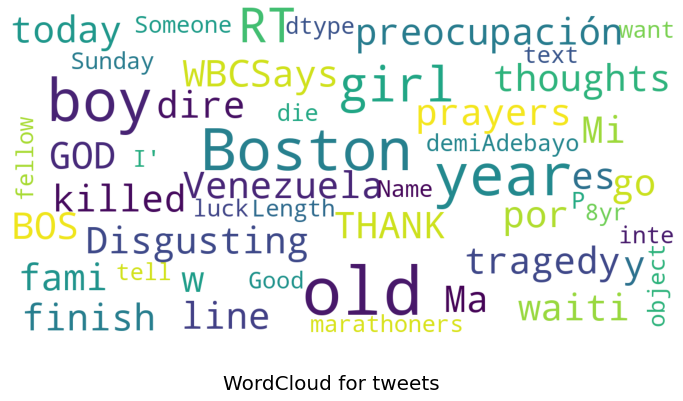

In [27]:
show_wordcloud(n['text'], "WordCloud for tweets")

In [29]:
#top N-gram sequential words used in covid tweets (count vectorizer, bag of words, )
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df
unigram_df=ngram_df(n['text'],(1,1),20)
bigram_df=ngram_df(n['text'],(2,2),20)
trigram_df=ngram_df(n['text'],(3,3),20)


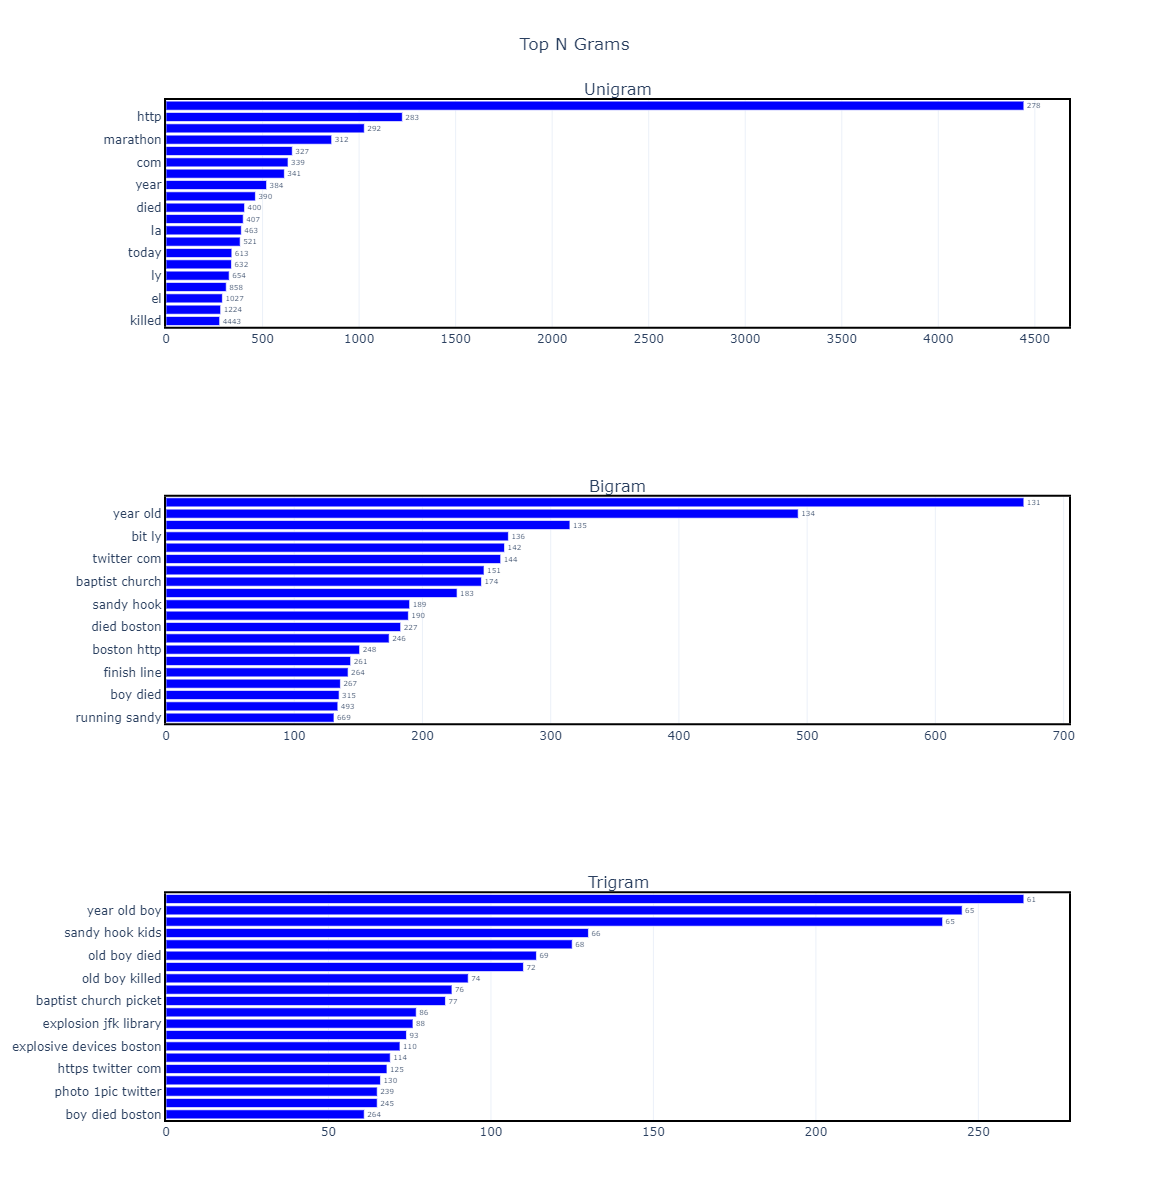

In [30]:
fig = make_subplots(
    rows=3, cols=1,subplot_titles=("Unigram","Bigram",'Trigram'),
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]
          ])

fig.add_trace(go.Bar(
    y=unigram_df['text'][::-1],
    x=unigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=unigram_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_df['text'][::-1],
    x=bigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=bigram_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_df['text'][::-1],
    x=trigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=trigram_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top N Grams',xaxis_title=" ",yaxis_title=" ", showlegend=False,title_x=0.5,
                  height=1200,template="plotly_white")
fig.show()